# Data

## Data Sources
1. Home and rent prices - Zillow: https://www.zillow.com/research/data/
2. Demographics - ACS: https://www.census.gov/programs-surveys/acs
3. Crime - FBI: https://ucr.fbi.gov/crime-in-the-u.s
4. Unemployment - BLS: https://www.bls.gov/data/
5. School ratings - GreatSchools: https://www.greatschools.org/
6. Public transportation - EPA: https://www.epa.gov/smartgrowth/smart-location-mapping
7. Natural disasters - FEMA: https://www.fema.gov/data-feeds
8. Distance to Disney World - Google Maps API: https://developers.google.com/maps/documentation

## Undocumented data sources
1. average size of home in sqft (probably Census)
2. PPI for maintenance expenses / average home expenses (probably BLS)

# Data Download

In [1]:
import pandas as pd

# Read the Zillow CSV file into a pandas DataFrame
zillow = pd.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvi/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1742438344")

# Filter only the data for the city of Orlando, FL
orlando_zillow = zillow[zillow['City'] == 'Orlando']

# Remove all columns except for the RegionID, RegionName, and columns for years
orlando_zillow = orlando_zillow.drop(columns=['RegionType', 'RegionID', 'State', 'StateName', 'SizeRank', 'City', 'Metro', 'CountyName', 'RegionID', 'SizeRank'])

# Exploratory Analysis

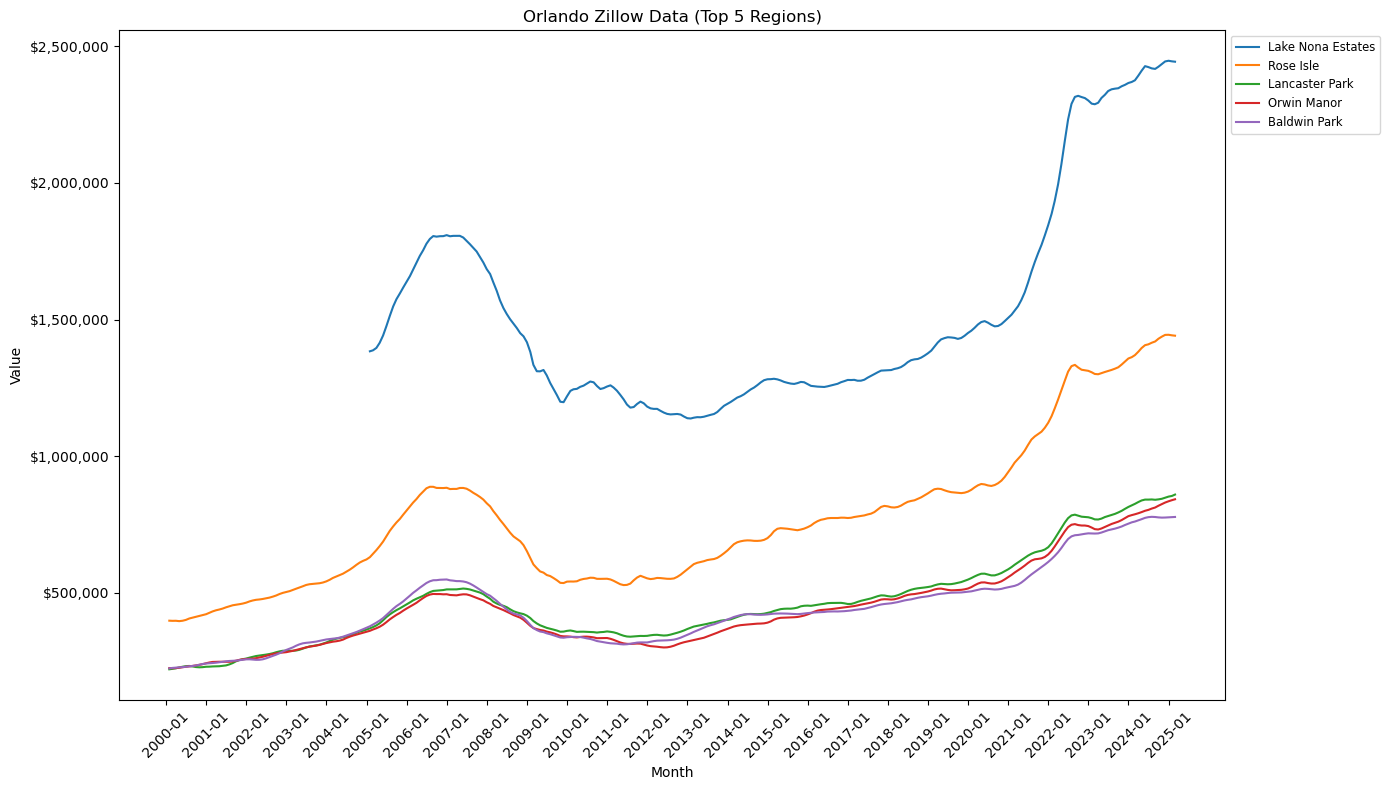

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert the wide format data into a long format
orlando_zillow_long = orlando_zillow.melt(id_vars=['RegionName'], var_name='month', value_name='value')
orlando_zillow_long['month'] = pd.to_datetime(orlando_zillow_long['month'])

# Calculate the median 2024 home prices for each neighborhood
median_2024_prices = orlando_zillow_long[orlando_zillow_long['month'].dt.year == 2024].groupby('RegionName')['value'].median()

# Get the top 5 neighborhoods with the highest median 2024 home prices
top_5_neighborhoods = median_2024_prices.nlargest(5).index

# Filter the data for these top 5 neighborhoods
filtered_data = orlando_zillow_long[orlando_zillow_long['RegionName'].isin(top_5_neighborhoods)]

# Plot the data
plt.figure(figsize=(14, 8))  # Expand the size of the plot
for neighborhood in top_5_neighborhoods:
  neighborhood_data = filtered_data[filtered_data['RegionName'] == neighborhood]
  plt.plot(neighborhood_data['month'], neighborhood_data['value'], label=neighborhood)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Orlando Zillow Data (Top 5 Regions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')

# Format y-axis as US dollars
formatter = ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Show only the first month of each year on the x-axis
unique_months = orlando_zillow_long['month'].dt.to_period('M').drop_duplicates().dt.to_timestamp()
yearly_months = unique_months[unique_months.dt.month == 1]
plt.xticks(
  ticks=yearly_months,
  labels=yearly_months.dt.strftime('%Y-%m'),
  rotation=45
)

plt.tight_layout()
plt.show()

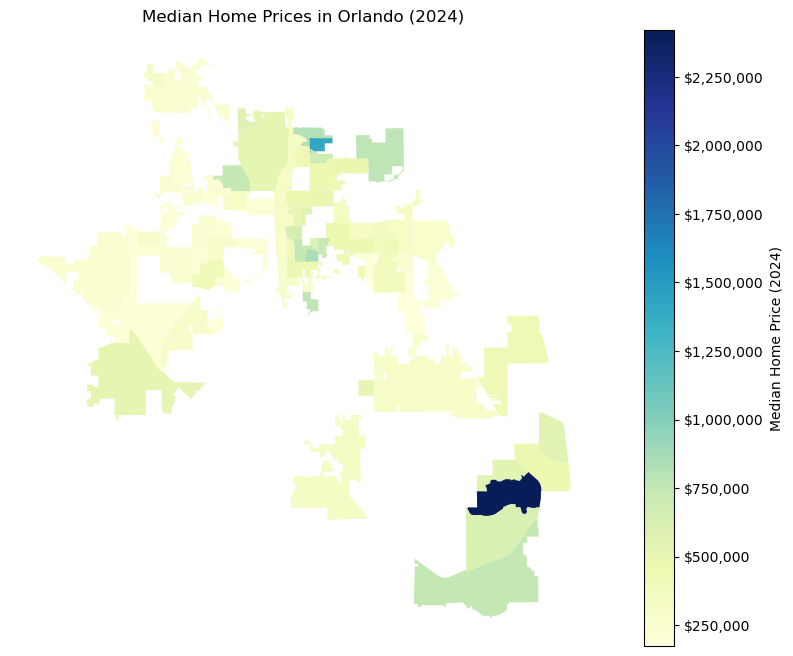

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load a GeoJSON file containing the geographical boundaries of Orlando neighborhoods
orlando_geo = gpd.read_file("orlando.geojson")

# Calculate the median home price for each region in 2024
orlando_zillow_long['year'] = pd.to_datetime(orlando_zillow_long['month']).dt.year
median_prices_2024 = orlando_zillow_long[orlando_zillow_long['year'] == 2024].groupby('RegionName')['value'].median()

# Merge the median prices with the GeoDataFrame
orlando_geo = orlando_geo.merge(median_prices_2024, left_on='name', right_index=True, how='left')

# Plot the chloropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
orlando_geo.plot(column='value', cmap='YlGnBu', legend=True, legend_kwds={'label': "Median Home Price (2024)"}, ax=ax)

# Format the legend to display in USD
formatter = FuncFormatter(lambda x, _: f'${x:,.0f}')
colorbar = ax.get_figure().axes[-1]  # Get the colorbar axis
colorbar.yaxis.set_major_formatter(formatter)

plt.title("Median Home Prices in Orlando (2024)")
plt.axis('off')
plt.show()